In [49]:
import pandas as pd
import re
from collections import Counter
import time
import os
from joblib import dump, load
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split




In [50]:
# Load the JSON file into a pandas DataFrame
loading_path = 'datasets/sp500_ten_year_dictionaries.json'
storing_path = 'datasets/sp500_ten_year_flatterned.json'

if not os.path.exists(storing_path):
  documents_df = pd.read_json(loading_path)
  df_list = [pd.DataFrame(d) for d in documents_df['document_df']]

  # Concatenate all the DataFrames
  flat_df = pd.concat(df_list, ignore_index=True)
  flat_df_notab = flat_df[flat_df['type'].isin(['table', 'image']) == False]

  df_original = flat_df_notab[['token_count', 'text']]

  # remove rows with NaN in 'text' column
  df_original = df_original.dropna(subset=['text'])
  # remove rows with empty string, whitespace, or new line only in 'text' column
  df_original = df_original[df_original['text'].str.strip() != '']
  df_original.reset_index(drop=True, inplace=True)

  df_original.to_json(storing_path)

else:
  df_original = pd.read_json(storing_path)


In [51]:
def analyze_text(x):
    # Use Counter for efficient character counting
    counter = Counter(x)

    # Quotations, alphanumeric, and escape characters still need regex

    # Direct calculations from Counter
    spaces_count = counter[' ']
    esc_char_count = counter['\\']
    quotation_count = sum(counter[char] for char in '\'"`“”')
    alpha_count = sum(count for char, count in counter.items() if char.isalpha())
    digit_count = sum(count for char, count in counter.items() if char.isdigit())
    dash_underscore_count = sum(counter[char] for char in '-_—')
    unique_char_count = len(counter)

    # Calculated fields
    char_count = len(x)
    word_len_estim = alpha_count / (spaces_count + 1)

    return char_count, spaces_count, quotation_count, dash_underscore_count, alpha_count, digit_count, unique_char_count, esc_char_count, word_len_estim


def preprocess_token_estimator(df, log_time = False):
    if log_time: start_time = time.time()

    # Apply the analyze_text function using map, resulting in a Series of tuples
    analysis_results = df['text'].map(lambda x: analyze_text(x))

    # Naming the result columns
    columns = ['char_count', 'spaces_count', 'quotation_count', 'dash_underscore_count', 'alpha_count', 'digit_count', 'unique_char_count', 'esc_char_count', 'word_len_estim']

    # Convert the Series of tuples into a DataFrame
    df_result = pd.DataFrame(analysis_results.tolist(), index=df.index,
                             columns = columns)


    if log_time:
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"{len(df)} samples processed in: {elapsed_time:>20.4f} seconds")
        print(f"Processing time for 1000 samples: {1000*elapsed_time/len(df):>16.6f} seconds")

    return df_result

# Joining the result with the original DataFrame if needed
df_preprocessed = preprocess_token_estimator(df_original, True)
df_preprocessed = pd.concat([df_original, df_preprocessed], axis=1)

df_preprocessed.head()

3513813 samples processed in:              86.0781 seconds
Processing time for 1000 samples:         0.024497 milliseconds


,token_count,text,char_count,spaces_count,quotation_count,dash_underscore_count,alpha_count,digit_count,unique_char_count,esc_char_count,word_len_estim
0,5,Content before First Item.,26,3,0,0,22,0,15,0,5.500000
1,3,3M COMPANY,10,1,0,0,8,1,9,0,4.000000
2,4,FORM 10-K,9,1,0,1,5,2,9,0,2.500000
3,9,"For the Year Ended December 31, 2023",36,6,0,0,23,6,21,0,3.285714
4,3,3M COMPANY,10,1,0,0,8,1,9,0,4.000000


In [52]:
storing_path = 'datasets/sp500_ten_year_preprocessed.json'

if not os.path.exists(storing_path):
  s_size = 1_100_000
  sample_total = (df_preprocessed.sample(s_size*3))

  subset_1 = sample_total.iloc[:s_size]
  subset_2 = sample_total.iloc[s_size:2*s_size]
  subset_3 = sample_total.iloc[2*s_size:]

  df_preprocessed.to_json(storing_path)
  subset_1.to_json('datasets/token_estimator_sample1.json')
  subset_2.to_json('datasets/token_estimator_sample2.json')
  subset_3.to_json('datasets/token_estimator_sample3.json')

  df = subset_1

else:
  df = pd.read_json('datasets/token_estimator_sample1.json')

df.head()

,token_count,text,char_count,spaces_count,quotation_count,dash_underscore_count,alpha_count,digit_count,unique_char_count,esc_char_count,word_len_estim
964369,8,4. FAIR VALUE — (CONTINUED),27,4,0,0,18,1,19,0,3.600000
958714,29,The following table summarizes changes in the ...,141,20,0,0,108,10,31,0,5.142857
2597859,154,"We lease ocean transport vessels, tugboats, ba...",841,121,0,0,681,16,44,0,5.581967
413669,87,We are subject to U.S. Federal income tax as w...,420,65,0,1,333,10,42,0,5.045455
58812,47,"On December 7, 2018, the Board of Directors de...",208,35,0,0,145,21,38,0,4.027778


In [53]:
variables_to_delete = [
    "flat_df", "flat_df_notab", "df_preprocessed", "sample_total",
    "df_original", "subset_2", "subset_3", "subset_1", "documents_df", "df_list"
]

for var in variables_to_delete:
    if var in globals():
        del globals()[var]


# Train Test Val SPlit


In [54]:
def train_val_test_split(df):
    # Split into test and remaining data
    df_remaining, df_test = train_test_split(df, test_size=100000, random_state=3362)

    # Split remaining data into train and validation
    df_train, df_validation = train_test_split(df_remaining, test_size=0.2, random_state=3362)

    # Your target variable
    y_train = df_train['token_count']
    y_validation = df_validation['token_count']
    y_test = df_test['token_count']

    # Your feature variables
    X_train = df_train.drop('token_count', axis=1)
    X_validation = df_validation.drop('token_count', axis=1)
    X_test = df_test.drop('token_count', axis=1)

    print("Training set shape:\t", X_train.shape, y_train.shape)
    print("Validation set shape:\t", X_validation.shape, y_validation.shape)
    print("Test set shape:\t\t", X_test.shape, y_test.shape, '\n')
    print("Training columns:\n\t", (list(X_train.columns)))
    print("Target column:\n\t", y_train.name)

    # Save the preprocessed training set
    dump(X_train[['text']], 'datasets/preprocess/X_train.joblib')
    dump(X_validation[['text']], 'datasets/preprocess/X_validation.joblib')
    dump(X_test[['text']], 'datasets/preprocess/X_test.joblib') 

    # Save the other sets
    dump(y_train, 'datasets/preprocess/y_train.joblib')
    dump(y_validation, 'datasets/preprocess/y_validation.joblib')
    dump(y_test, 'datasets/preprocess/y_test.joblib')

    X_train.drop('text', axis=1, inplace=True)
    X_validation.drop('text', axis=1, inplace=True)
    X_test.drop('text', axis=1, inplace=True)


    return X_train, X_validation, X_test, y_train, y_validation, y_test

X_train, X_validation, X_test, y_train, y_validation, y_test =  train_val_test_split(df)

X_train_processed, X_validation_processed, X_test_processed, = X_train, X_validation, X_test
y_train_processed, y_validation_processed, y_test_processed = y_train, y_validation, y_test

Training set shape:	 (800000, 10) (800000,)
Validation set shape:	 (200000, 10) (200000,)
Test set shape:		 (100000, 10) (100000,) 

Training columns:
	 ['text', 'char_count', 'spaces_count', 'quotation_count', 'dash_underscore_count', 'alpha_count', 'digit_count', 'unique_char_count', 'esc_char_count', 'word_len_estim']
Target column:
	 token_count


# Preprocessing

In [55]:
# Define the columns you want to standardize
columns_to_scale = ['char_count', 'spaces_count', 'quotation_count',
                    'dash_underscore_count', 'alpha_count', 'digit_count',
                    'unique_char_count','esc_char_count','word_len_estim']

# Create a Pipeline that standardizes the data
pipeline_first = Pipeline([
    ('scaler', StandardScaler()),
    ('minMax', MinMaxScaler())
])

# Now you can fit and transform your datasets using this pipeline
# Note: You should fit the scaler only on the training data, then transform both the validation and test data.

# Fit on training data and transform it
X_train = pipeline_first.fit_transform(X_train[columns_to_scale])

# Transform validation and test data
X_validation = pipeline_first.transform(X_validation[columns_to_scale])
X_test = pipeline_first.transform(X_test[columns_to_scale])

# If you need to add these standardized values back to your original DataFrames,
# here is an example of how to do it for the training data:
import pandas as pd

# Assuming X_train is a pandas DataFrame
pd.DataFrame(X_train).describe().T

dump(pipeline_first, 'models/preprocessing_pipeline')



['models/preprocessing_pipeline']

# First Classifiler 

Prediction time for 1000 samples:  0.0047361207008361815
Validation Accuracy:  0.01725

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       358
           1       0.99      0.99      0.99     88505
           2       0.94      0.94      0.94     34871
           3       0.95      0.95      0.95     42011
           4       0.96      0.95      0.95     29165
           5       0.95      0.92      0.94      5090

    accuracy                           0.97    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.97      0.97      0.97    200000



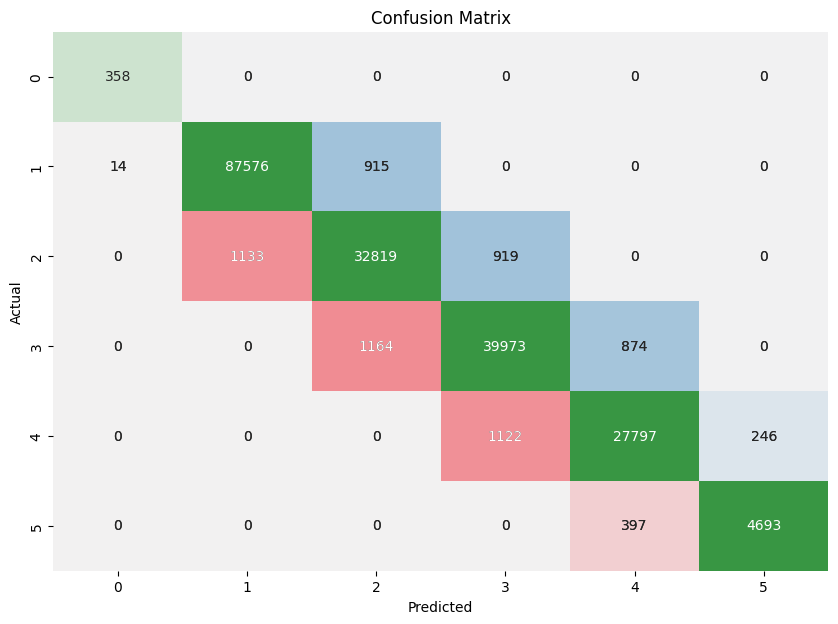

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.colors import Normalize
import numpy as np




# Define the bins for the classes
bins = [0, 32, 64, 128, 256, np.inf]
labels = [1, 2, 3, 4, 5]

# Convert the target to ordinal classes
y_train_binned = np.digitize(y_train, bins, right=True)
y_validation_binned = np.digitize(y_validation, bins, right=True)

# Create a Random Forest Classifier model
model = RandomForestClassifier(
                                n_estimators=100,
                                n_jobs=-1)

# Train the model
model.fit(X_train, y_train_binned)

# Make predictions on the validation set
start = time.time()
y_pred = model.predict(X_validation)
print("Prediction time for 1000 samples: ", 1000*(time.time()-start)/len(y_validation))

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_validation_binned, y_pred)

print("Validation Accuracy: ", accuracy)



# Generate the classification report
class_report = classification_report(y_validation_binned, y_pred)

print("\nClassification Report:")
print(class_report)

# Generate the confusion matrix
conf_mat = confusion_matrix(y_validation_binned, y_pred)

# Create a mask for the upper triangle
mask1 = np.triu(np.ones_like(conf_mat, dtype=bool))
mask2 = np.tril(np.ones_like(conf_mat, dtype=bool))

# Create a custom colormap
matrix_sum = np.sum(conf_mat)

cmap1 = sns.diverging_palette(250, 10, s=80, l=55, as_cmap=True,)
cmap2 = sns.diverging_palette(20, 240, s=80, l=55, as_cmap=True, )
cmap3 = sns.diverging_palette(120, 130, s=80, l=55, as_cmap=True,)
norm = Normalize(vmin=0, vmax=matrix_sum/100)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=cmap3, norm=norm, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask1, norm=norm, cmap=cmap1, center=0, cbar=False)
sns.heatmap(conf_mat, annot=True, fmt='d', mask=mask2, norm=norm, cmap=cmap2, center=0, cbar=False)



# Labels, title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show plot
plt.show()

## Custom Evaluation Metrics

In [9]:
import numpy as np

import numpy as np

def calculate_asymmetric_mean_squared_error(y_true, y_pred):
    # Ensure numpy arrays for vectorized operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate errors
    errors = y_pred - y_true

    # Identify underestimations more than 10%
    underestimations = errors < -0.1 * y_true
    underestim_percentage = np.mean(underestimations)
    underestim_adj = (1 + underestim_percentage)**5

    # Calculate squared errors with double penalty for underestimations
    squared_errors = np.where(errors < 0, (errors**2) * 2, errors**2)

    asymmetric_sqr_err = np.sum(squared_errors) / len(y_pred)
    # Adjusted sum of squared errors
    asymmetric_sqr_err_adj = asymmetric_sqr_err * underestim_adj


    print()
    print('-'*40)
    print('underestim_percentage:   ', underestim_percentage)
    print('underestim_adj:          ', underestim_adj)
    print('asymmetric_sqr_err:      ', asymmetric_sqr_err)
    print('asymmetric_sqr_err_adj:  ', asymmetric_sqr_err_adj)
    print('real mse (beancmark):    ', mean_squared_error(y_true, y_pred))
    print('-'*40)
    print()


    # Return square root of mean error
    return asymmetric_sqr_err_adj



import numpy as np

def custom_weighted_mse_obj( dtrain, y_true):
    # Extract the predictions from the DMatrix
    y_pred = dtrain#.get_label()

    # Calculate residuals (difference between prediction and true value)
    residuals = y_pred - y_true

    mask = residuals < 0
    percent_diff = (residuals[mask] / y_true[mask])

    partitioned_array = np.partition(percent_diff, 10)
    # The first 5 elements now contain the lowest values
    lowest_five = partitioned_array[:10]


    # Calculate the weight for negative differences
    w = (np.abs(np.sum(lowest_five)))

    w = (1+ ((w)**2))


    # Define the weights for overpredictions and underpredictions
    weight_overprediction = 1.0
    weight_underprediction = 2.0 * w

    # Calculate the gradient
    grad = np.where(residuals < 0, abs(weight_underprediction * residuals), residuals)

    # Calculate the Hessian (second derivative of loss with respect to prediction)
    # Since the loss is a quadratic function, the Hessian is constant
    hess = np.where(residuals < 0, weight_underprediction * np.ones_like(abs(residuals)), np.ones_like(residuals))

    # print('_'*40)
    # print('w', w)
    # print('u', weight_underprediction)
    # print('o', weight_overprediction)
    # # print('g', grad)
    # # print('h', hess)
    # print('_'*40)
    # print()

    return grad, hess



def custom_weighted_mse_obj(y_true, y_pred):
    # Calculate the difference
    diff = y_pred - y_true

    # Gradient: Double the penalty for underpredictions
    grad = np.where(diff < 0, 10 * diff, diff)

    # Hessian: Since the MSE's second derivative is constant, we'll treat it as such,
    # but acknowledge our gradient handles the asymmetry
    hess = np.ones_like(y_true)

    return grad, hess


def calculate_apt(prediction_time, val_dataset, smoothing=8, adj = 10):
1
    apt = adj*pt

    return apt


# Linear Regression

In [10]:
import time
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm  # Automatically use notebook-friendly version if in Jupyter


# Initialize and train the linear regression model
lreg = LinearRegression(n_jobs=-1)
lreg.fit(X_train, y_train)

start_time = time.time()
preds = lreg.predict(X_validation)
prediction_time = time.time() - start_time

amse = calculate_asymmetric_mean_squared_error(y_validation, preds)


apt = calculate_apt(prediction_time, y_validation)


tamse = amse * (apt)
print()
print('amse:  ', amse, 'time:', (1000*prediction_time)/ len(y_validation))
print('apt:   ', apt)
print('tamse: ', tamse)
print('~'*60)
print()


dump(lreg, 'models/lreg_fist')


----------------------------------------
underestim_percentage:    0.151265
underestim_adj:           2.02244401623911
asymmetric_sqr_err:       32.88164437248162
asymmetric_sqr_err_adj:   66.50128490522786
real mse (beancmark):     20.14724834027542
----------------------------------------


amse:   66.50128490522786 time: 8.405923843383789e-05
apt:    1.3048878320046429
tamse:  86.77671748550587
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



['models/lreg_fist']

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from optuna.visualization import plot_optimization_history, plot_param_importances


best_XGB= None
best_score = float('inf')


def objective(trial):
    global best_XGB
    global best_score

    param = {
        'verbosity': 1,
        'objective': 'reg:squarederror',  # Use 'reg:squarederror' for regression tasks
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'max_depth': trial.suggest_int('max_depth', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.25, 0.75),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'alpha': trial.suggest_float('alpha', 0, 50),
        'lambda': trial.suggest_float('lambda', 0, 50),
    }

    model = xgb.XGBRegressor(**param)
    # Use set_params to include early_stopping_
    model.set_params(early_stopping_rounds=5)

    model.fit(X_train, y_train, eval_set=[(X_validation, y_validation)],
              verbose=False,
              )

    start_time = time.time()
    preds = model.predict(X_validation)
    prediction_time = time.time() - start_time


    amse = calculate_asymmetric_mean_squared_error(y_validation, preds)
    apt = calculate_apt(prediction_time, y_validation)
    tamse = amse * (apt)

    print()
    print('amse:  ', amse, 'time:', (1000*prediction_time)/ len(y_validation))
    print('apt:   ', apt)
    print('tamse: ', tamse)
    print('~'*60)
    print()

    if tamse < best_score:
        best_score = tamse
        best_XGB = model

    return tamse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print()
print('/'*40)
print()
print('Number of finished trials:\n', len(study.trials))
best_params = study.best_trial.params
print(f"Best params: \n{best_params}")
best_score = study.best_trial.value
print(f"Best score (tamse): \n{best_score}")
print()


display(plot_optimization_history(study))
display(plot_param_importances(study))

dump(best_XGB, 'models/MLPR_fist')
dump(study, 'models/MLPR_fist_study')

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import time


best_XGB_asym = None
best_score = float('inf')


def objective(trial):
    global best_XGB_asym
    global best_score

    param = {
        'verbosity': 1,
        'objective': custom_weighted_mse_obj,  # Use 'reg:squarederror' for regression tasks
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        # 'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e0, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_float('alpha', 0, 50),
        'lambda': trial.suggest_float('lambda', 0, 50),
        # 'obj': custom_weighted_mse_obj

    }

    model = xgb.XGBRegressor(**param)
    # Use set_params to include early_stopping_
    model.set_params(early_stopping_rounds=10, eval_metric = calculate_asymmetric_mean_squared_error)

    model.fit(X_train, y_train, eval_set=[(X_validation, y_validation)],
              verbose=False,
              )

    start_time = time.time()
    preds = model.predict(X_validation)
    prediction_time = time.time() - start_time

    amse = calculate_asymmetric_mean_squared_error(y_validation, preds)
    apt = calculate_apt(prediction_time, y_validation)
    tamse = amse * (apt)

    print()
    print('amse:  ', amse, 'time:', (1000*prediction_time)/ len(y_validation))
    print('apt:   ', apt)
    print('tamse: ', tamse)
    print('~'*60)
    print()

    if tamse < best_score:
        best_score = tamse
        best_XGB_asym = model

    return tamse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print()

print('Number of finished trials:', len(study.trials))

best_params = study.best_trial.params
print(f"Best params: {best_params}")
best_score = study.best_trial.value
print(f"Best score (timed ASMSE): {best_score}")


display(plot_optimization_history(study))
display(plot_param_importances(study))

dump(best_XGB_asym, 'models/XGB_asym_fist')
dump(study, 'models/XGB_asym_fist_study')


In [ ]:
def generate_layers(features_number, total_neurons, layers_size):    
    # Calculate the maximum multiple of n that fits into total_neurons
    max_multiple = total_neurons // features_number * features_number
    
    # Calculate each layer value, except the last one
    layers = [features_number * (max_multiple // features_number // layers_size) for _ in range(layers_size - 1)]
    
    # Calculate the remainder as the last layer
    remainder = total_neurons - sum(layers)
    layers.append(remainder)
    layers = sorted(layers, reverse=True)
    # Convert list to tuple
    layers_tuple = tuple(layers)
    
    return layers_tuple


In [ ]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


best_MLPR = None
best_score = float('inf')

def objective(trial):
    global best_MLPR
    global best_score
    # Suggest hyperparameters
    n = X_train.shape[1] # Number of features
    total_neurons = trial.suggest_int('layer_sizes', low=n*20, high=n*70, step=n*10)
    layer_levels = trial.suggest_int('layer_levels', low=1, high=10)
    alpha = trial.suggest_float('alpha', 0.00001, 0.001, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 5e-4, 1e-3, log=True)

    layers = generate_layers(n, total_neurons, layer_levels)

    # Initialize and train MLPRegressor
    model = MLPRegressor(
                         hidden_layer_sizes=(layers),
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,

                         activation='relu',
                         solver='adam',
                         batch_size='auto',
                         max_iter=512,  # Adjust as necessary
                         early_stopping=True,  # Add early stopping
                         validation_fraction=0.2,  # Use 20% of the training data as validation data
                         n_iter_no_change=20,  # Stop training if the validation score doesn't improve for 10 consecutive epochs
                         )

    print()
    print('|'*60)
    print(f'Total Neutrons: {total_neurons}')
    print(f'Total Layers:   {layer_levels}') 
    print(f'Layers:         {layers}')
    print(f'Learning Rate:  {learning_rate_init}')
    print(f'Alpha:          {alpha}')
    print('|'*60)
    print()

    training_time_start = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - training_time_start
    print(f'Trainig time:               {round(training_time, 0)} minutes')
    print(f'Training time per neurorn:  {training_time/(total_neurons)}')

    start_time = time.time()
    preds = model.predict(X_validation)
    prediction_time = time.time() - start_time

    amse = calculate_asymmetric_mean_squared_error(y_validation, preds)
    apt = calculate_apt(prediction_time, y_validation)
    tamse = amse * (apt)

    print('amse:  ', amse, 'time:', (1000*prediction_time)/ len(y_validation))
    print('apt:   ', apt)
    print('tamse: ', tamse)
    print('~'*60)
    print()

    if tamse < best_score:
        best_score = tamse
        best_MLPR = model

    return tamse



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('\nNumber of finished trials:', len(study.trials))

best_params = study.best_trial.params
print(f"Best params: {best_params}")
best_score = study.best_trial.value
print(f"Best score (AMSE): {best_score}")

display(plot_optimization_history(study))
display(plot_param_importances(study))

dump(best_MLPR, 'models/MLPR_fist')
dump(study, 'models/MLPR_fist_study')

# Visualize Results


/Users/emanueleferrari/VSCode/SEC_Cleaner/CleanerSEC/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



LinearRegression

----------------------------------------
underestim_percentage:    0.15226
underestim_adj:           2.0311987911450657
asymmetric_sqr_err:       32.498519538482604
asymmetric_sqr_err_adj:   66.01095360057016
real mse (beancmark):     19.935766358641352
----------------------------------------



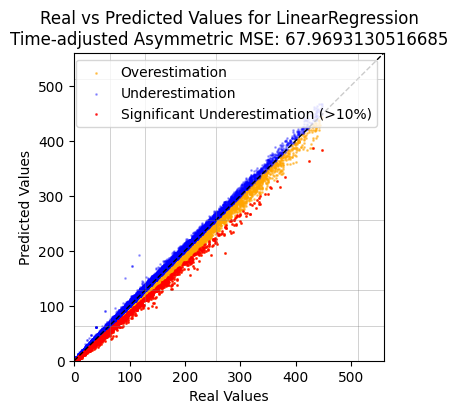


Best_XGB

----------------------------------------
underestim_percentage:    0.10313
underestim_adj:           1.6335539333051796
asymmetric_sqr_err:       31.313885749479905
asymmetric_sqr_err_adj:   51.15292123313191
real mse (beancmark):     19.020302981062617
----------------------------------------



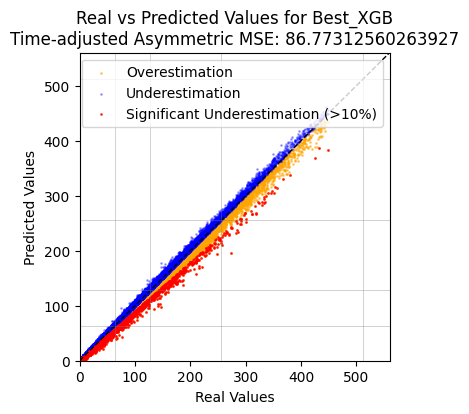


Best_XGB_asym

----------------------------------------
underestim_percentage:    0.04128
underestim_adj:           1.224158449652534
asymmetric_sqr_err:       53.928023946322845
asymmetric_sqr_err_adj:   66.0164461869553
real mse (beancmark):     44.19788046371581
----------------------------------------



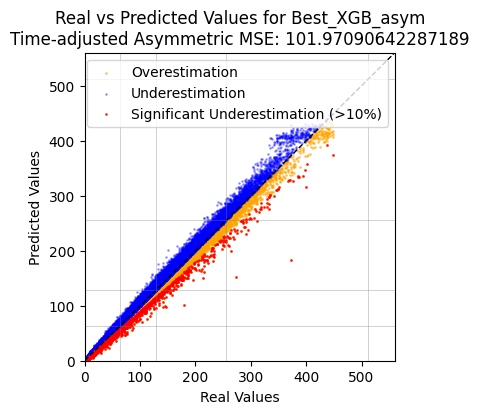


Best_MLPR

----------------------------------------
underestim_percentage:    0.10313
underestim_adj:           1.6335539333051796
asymmetric_sqr_err:       31.313885749479905
asymmetric_sqr_err_adj:   51.15292123313191
real mse (beancmark):     19.020302981062617
----------------------------------------



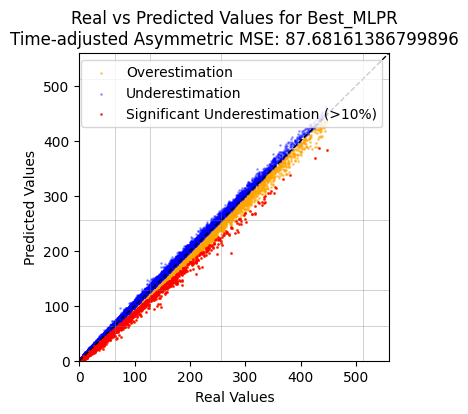

,Model,time_for_1000,mean_squared_error,amse,adj proc time,tamse
0,LinearRegression,0.000025,19.935766,66.010954,1.029667,67.969313
1,Best_XGB,0.001371,19.020303,51.152921,1.696347,86.773126
2,Best_XGB_asym,0.000648,44.197880,66.016446,1.544629,101.970906
3,Best_MLPR,0.001491,19.020303,51.152921,1.714108,87.681614


In [11]:
%matplotlib inline

model_dict = {
    "LinearRegression": load('models/lreg_fist'),
    "Best_XGB": load('models/MLPR_fist'),
    "Best_XGB_asym": load('models/XGB_asym_fist'),
    "Best_MLPR": load('models/MLPR_fist')
}

# Placeholder for results
results = []
model_pred = {}

# Step 2: Iterate over each model to predict and calculate metrics
for model_name, model in model_dict.items():
    print()
    print(model_name)

    start_time = time.time()
    preds = model.predict(X_test)
    prediction_time = time.time() - start_time

    time_for_1000 = (1000*prediction_time)/ len(y_test)

    amse = calculate_asymmetric_mean_squared_error(y_test, preds)
    apt = calculate_apt(prediction_time, y_test)
    tamse = amse * (apt)

    # Store results
    results.append({
        "Model": model_name,
        "time_for_1000": time_for_1000,
        "mean_squared_error": mean_squared_error(y_test, preds),

        "amse": amse,
        "adj proc time": apt,
        "tamse": tamse,

    })

    overestimated = y_test >= preds
    underestimated = y_test < preds
    significantly_underestimated = y_test*0.9 > preds  # Predictions more than 10% lower than the real values

    # Plot setup
    plt.figure(figsize=(4, 4))


    # Scatter plots for different categories
    plt.scatter(y_test[overestimated], preds[overestimated], color='orange', alpha=0.5, s=1, label='Overestimation')
    plt.scatter(y_test[underestimated], preds[underestimated], color='blue', alpha=0.3, s=1, label='Underestimation')
    plt.scatter(y_test[significantly_underestimated], preds[significantly_underestimated], color='red', alpha=0.7, s=1, label='Significant Underestimation (>10%)')

    # Diagonal line for reference
    plt.plot([0, 600], [0, 600], 'k--', lw=1)
    # other reference lines
    plt.plot([64, 64], [0, 600], 'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width
    plt.plot([0, 600], [64, 64],  'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width
    plt.plot([128, 128], [0, 600], 'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width
    plt.plot([0, 600], [128, 128],  'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width
    plt.plot([256, 256], [0, 600], 'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width
    plt.plot([0, 600], [256, 256],  'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width
    plt.plot([512, 512], [0, 600], 'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width
    plt.plot([0, 600], [512, 512],  'grey', linestyle='-', lw=0.5, alpha=0.5)  # lw is line width


    # Labels, title, and limits
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Real vs Predicted Values for {model_name}\nTime-adjusted Asymmetric MSE: {tamse}')
    plt.xlim([0, 560])
    plt.ylim([0, 560])

    # Legend
    plt.legend()

    # Show plot
    plt.show()

    # Optionally, store results in a dict as well
    model_pred[model_name] = preds

# Step 3: Convert results to a Pandas DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
display(results_df)


In [12]:
from sklearn.base import TransformerMixin, BaseEstimator

class AppendPrediction(TransformerMixin, BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        model.fit(X)
        return self

    def transform(self, X):
        # Predict using the provided model
        predictions = self.model.predict(X)
        df = np.column_stack((X, predictions/512))
        df = pd.DataFrame(df, columns=['char_count', 'spaces_count', 'quotation_count',
       'dash_underscore_count', 'alpha_count', 'digit_count',
       'unique_char_count', 'esc_char_count', 'word_len_estim', 'linreg_estim'])

        # Append predictions as a new column
        return df

# Create a new pipeline using the trained 'pipeline_first' and adding a linear regression step
complete_pipeline = Pipeline([
    ('preprocessing', pipeline_first),   # Trained preprocessing pipeline
    ('append_prediction', AppendPrediction(lreg))  # Appends predictions to the original data
])

X_train_with_estim = complete_pipeline.transform(X_train_processed)
X_validation_with_estim = complete_pipeline.transform(X_validation_processed)
X_test_with_estim = complete_pipeline.transform(X_test_processed)

display(X_train_with_estim.describe().T)


,count,mean,std,min,25%,50%,75%,max
char_count,800000.0,0.131193,0.142478,0.000000,0.021445,0.079007,0.196388,1.000000
spaces_count,800000.0,0.126477,0.140046,0.000000,0.017115,0.075795,0.190709,1.000000
quotation_count,800000.0,0.003494,0.013975,0.000000,0.000000,0.000000,0.000000,1.000000
dash_underscore_count,800000.0,0.007158,0.014453,0.000000,0.000000,0.000000,0.009615,1.000000
alpha_count,800000.0,0.126467,0.137904,0.000000,0.021400,0.075346,0.188141,1.000000
digit_count,800000.0,0.016937,0.032844,0.000000,0.000000,0.000000,0.020290,1.000000
unique_char_count,800000.0,0.414835,0.164271,0.000000,0.289855,0.420290,0.536232,1.000000
esc_char_count,800000.0,0.000004,0.001936,0.000000,0.000000,0.000000,0.000000,1.000000
word_len_estim,800000.0,0.148707,0.037361,0.000000,0.131333,0.144110,0.158606,1.000000
linreg_estim,800000.0,0.130431,0.140052,-0.006521,0.021696,0.080964,0.196203,0.908889


In [13]:
y_train_reset = y_train.reset_index(drop=True)
y_validation_reset = y_validation.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

indexes = X_train_with_estim.index[(X_train_with_estim['linreg_estim']*512 < y_train_reset*0.9)]

# Create the 'is_in_group' column
X_train_with_estim['underestimation'] = (X_train_with_estim['linreg_estim']*512 < y_train_reset*0.9).astype(int)

# Compute the correlation matrix
correlation_matrix = X_train_with_estim.corr()

# Print the correlation of 'is_in_group' with other variables
print(X_train_with_estim['underestimation'].value_counts(normalize=True))
print()
print(correlation_matrix['underestimation'])
X_train_with_estim.drop('underestimation', axis=1, inplace=True)


underestimation
0    0.847823
1    0.152177
Name: proportion, dtype: float64

char_count              -0.295912
spaces_count            -0.297651
quotation_count         -0.080864
dash_underscore_count   -0.145615
alpha_count             -0.292707
digit_count             -0.161535
unique_char_count       -0.457533
esc_char_count           0.000977
word_len_estim           0.007733
linreg_estim            -0.302857
underestimation          1.000000
Name: underestimation, dtype: float64


Variance retained with 2 components: 0.9754864425841907
Variance lost with 2 components: 0.024513557415809295
Variance retained with 3 components: 0.9880645531882152
Variance lost with 3 components: 0.011935446811784822


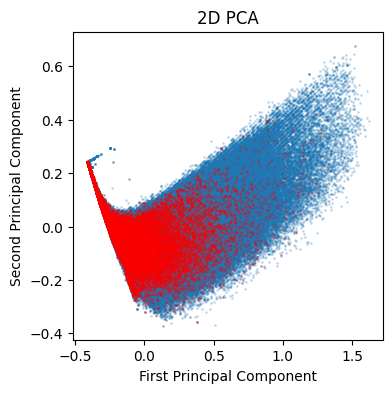

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Initialize PCA and reduce dimensions to 3
pca_3 = PCA(n_components=3)
pca_3_results = pca_3.fit_transform(X_train_with_estim)

# Reduce dimensions to 2
pca_2 = PCA(n_components=2)
pca_2_results = pca_2.fit_transform(X_train_with_estim)

variance_lost_2 = 1 - sum(pca_2.explained_variance_ratio_)
variance_lost_3 = 1 - sum(pca_3.explained_variance_ratio_)

print("Variance retained with 2 components:", pca_2.explained_variance_ratio_.sum())
print("Variance lost with 2 components:", variance_lost_2)
print("Variance retained with 3 components:", pca_3.explained_variance_ratio_.sum())
print("Variance lost with 3 components:", variance_lost_3)


# Convert indexes to set for faster lookup
indexes_set = set(indexes)

# 2D PCA plot
plt.figure(figsize=(4,4))
plt.scatter(pca_2_results[:, 0], pca_2_results[:, 1], s=1, alpha=0.2)
plt.scatter(pca_2_results[indexes, 0], pca_2_results[indexes, 1], s=1, alpha=0.2, color='red')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D PCA')
plt.show()


In [15]:
# %matplotlib widget

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Your PCA plot code
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pca_3_results[:, 1], pca_3_results[:, 2], pca_3_results[:, 0], s=2, alpha=0.01)
# ax.scatter(pca_3_results[indexes, 1], pca_3_results[indexes, 2], pca_3_results[indexes, 0], s=2, alpha=0.6, color='red')
# ax.set_xlabel('First Principal Component')
# ax.set_ylabel('Second Principal Component')
# ax.set_zlabel('Third Principal Component')
# ax.set_title('3D PCA')
# plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Create target variable based on condition
y_train = (X_train_with_estim['linreg_estim']*512 < y_train_reset*0.9)
y_validation = (X_validation_with_estim['linreg_estim']*512 < y_validation_reset*0.9)
y_test = (X_test_with_estim['linreg_estim']*512 < y_test_reset*0.9)

# Initialize models
logistic_regression = LogisticRegression(C=1000, max_iter=1000, n_jobs=-1)
random_forest = RandomForestClassifier(n_estimators=10, n_jobs=-1)
xgboost = XGBClassifier(n_estimators=100, n_jobs=-1)
# lightgbm = LGBMClassifier(n_estimators=100, n_jobs=-1)

# Fit models
logistic_regression.fit(X_train_with_estim, y_train)
random_forest.fit(X_train_with_estim, y_train)
xgboost.fit(X_train_with_estim, y_train)

# Evaluate models on validation set
models = [
            logistic_regression, 
            random_forest, 
            xgboost,
            ]
model_names = [
                'Logistic Regression', 
                'Random Forest', 
                'XGBoost',
               ]

for i, model in enumerate(models):
    time_start = time.time()
    y_pred = model.predict(X_validation_with_estim)
    elapsed_time = time.time() - time_start
    print()
    print(f"{model_names[i]} prediction time: {elapsed_time:.4f} seconds")
    print(f"time for 1000 samples:            {((1000*elapsed_time)/len(X_validation_with_estim)):.4f} seconds")
    print(f"F1 Score:                         {f1_score(y_validation, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_validation, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_validation, y_pred)}")
    print()
    print('-'*40)

# Choose the best model based on validation performance and test it on the test set
y_pred_test = random_forest.predict(X_test_with_estim)
print(f"Test F1: {f1_score(y_test, y_pred_test)}")
print(f"Test Classification Report:\n{classification_report(y_test, y_pred_test)}")




Logistic Regression prediction time: 0.0261 seconds
time for 1000 samples:            0.0001 seconds
F1 Score:                         0.5836980064536091
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95    169747
        True       0.88      0.44      0.58     30253

    accuracy                           0.91    200000
   macro avg       0.89      0.71      0.77    200000
weighted avg       0.90      0.91      0.89    200000

Confusion Matrix:
[[167959   1788]
 [ 17048  13205]]

----------------------------------------

Random Forest prediction time: 0.1725 seconds
time for 1000 samples:            0.0009 seconds
F1 Score:                         0.7819445220663575
Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97    169747
        True       0.90      0.69      0.78     30253

    accuracy                           0.94    200000
   macro a

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

def objective(trial):
    n_estimators = 2 ** trial.suggest_int("n", 2, 7)
    max_depth = 10 * trial.suggest_int("max_depth", 4, 12)
    # min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,

        n_jobs=-1)

    print()
    print('|'*60)
    print(f'n_estimators:        {n_estimators}')
    print(f'max_depth:           {max_depth}')
    # print(f'min_samples_split:   {min_samples_split}')
    print(f'min_samples_leaf:    {min_samples_leaf}')
    print('-'*40)

    time_start = time.time()
    clf.fit(X_train_with_estim, y_train)
    elapsed_time = time.time() - time_start

    print()
    print(f"Training time:        {elapsed_time:.4f} seconds")

    time_start = time.time()    
    y_pred_train = clf.predict(X_train_with_estim)
    elapsed_time = time.time() - time_start
    print(f"time for 1000 samples: {((1000*elapsed_time)/len(X_train_with_estim)):.4f} seconds")


    y_pred_valid = clf.predict(X_validation_with_estim)
    
    f1_train = f1_score(y_train, y_pred_train)
    f1_valid = f1_score(y_validation, y_pred_valid)

    print()
    print(f"F1 Train:              {f1_train:.4f}")
    print(f"F1 Valid:              {f1_valid:.4f}")
    
    trial.set_user_attr(key="f1_train", value=f1_train)
    trial.set_user_attr(key="f1_valid", value=f1_valid)
    
    return f1_valid

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=20)

# best_forest = RandomForestClassifier(**study.best_params)
# best_forest.fit(X_train_with_estim, y_train)

print()
print("Best Trial:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_param_importances(study))

print(study.best_params)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Initialize model
random_forest = RandomForestClassifier(n_estimators=20, max_depth=80, n_jobs=-1)

y_train = (X_train_with_estim['linreg_estim'] < (y_train_reset*0.9)/512)
y_validation = (X_validation_with_estim['linreg_estim'] < (y_validation_reset*0.9)/512)
y_test = (X_test_with_estim['linreg_estim'] < (y_test_reset*0.9)/512)

# Fit model
random_forest.fit(X_train_with_estim, y_train)

# Evaluate model on train, validation and test sets
sets = [('Train', X_train_with_estim, y_train), 
        ('Validation', X_validation_with_estim, y_validation), 
        ('Test', X_test_with_estim, y_test)]

for set_name, X_set, y_set in sets:
    time_start = time.time()
    y_pred = random_forest.predict(X_set)
    elapsed_time = time.time() - time_start
    print(f'{set_name} prediction time for 1000 samples: {((1000*elapsed_time)/len(X_set)):.4f} seconds')
    print(f"{set_name} F1 Score: {f1_score(y_set, y_pred)}")
    print(f"{set_name} Classification Report:\n{classification_report(y_set, y_pred)}")
    print(f"{set_name} Confusion Matrix:\n{confusion_matrix(y_set, y_pred)}")
    print('-'*40)


Train prediction time for 1000 samples: 0.0013 seconds
Train F1 Score: 0.8886872642185187
Train Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98    678258
        True       0.94      0.84      0.89    121742

    accuracy                           0.97    800000
   macro avg       0.96      0.92      0.93    800000
weighted avg       0.97      0.97      0.97    800000

Train Confusion Matrix:
[[672004   6254]
 [ 19387 102355]]
----------------------------------------
Validation prediction time for 1000 samples: 0.0011 seconds
Validation F1 Score: 0.7867902449896915
Validation Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97    169747
        True       0.90      0.70      0.79     30253

    accuracy                           0.94    200000
   macro avg       0.92      0.84      0.88    200000
weighted avg       0.94      0.94      0.94    2

# PREPROCESSING PIPELINE


In [18]:
def preprocess_token_estimator(df):
    df=pd.DataFrame(df)
    # Apply the analyze_text function using map, resulting in a Series of tuples
    analysis_results = df['text'].map(lambda x: analyze_text(x))

    # Naming the result columns
    columns = ['char_count', 'spaces_count', 'quotation_count', 'dash_underscore_count', 'alpha_count', 'digit_count', 'unique_char_count', 'esc_char_count', 'word_len_estim']

    # Convert the Series of tuples into a DataFrame
    df_result = pd.DataFrame(analysis_results.tolist(), index=df.index,
                             columns = columns)

    return df_result


In [21]:
class AppendPrediction(TransformerMixin, BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def transform(self, X):
        # Predict using the provided model
        predictions = self.model.predict(X)
        predictions = np.clip(predictions, 0, None)
        df = np.column_stack((X, predictions/512))

        # Append predictions as a new column
        return df

    
class AppendUnderestimationClassifiler(TransformerMixin, BaseEstimator):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None):
        self.model.fit(X, (X[:,-1] < (y*0.9)/512))
        return self

    def transform(self, X):
        # Predict using the provided model
        predictions = self.model.predict(X)
        df = np.column_stack((X, predictions.astype(int)))

        # Append predictions as a new column
        return df
    
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.func(X)
    
random_forest = RandomForestClassifier(n_estimators=20, max_depth=80, n_jobs=-1)

# Create a new pipeline using the trained 'pipeline_first' and adding a linear regression step
preprocess_pipeline = Pipeline([
    ('preprocess_token_estimator', FeatureEngineering(preprocess_token_estimator)),
    ('preprocessing', pipeline_first),   # Trained preprocessing pipeline
    ('append_prediction', AppendPrediction(lreg)),  # Appends predictions to the original data
    ('append_underestimation_class', AppendUnderestimationClassifiler(random_forest)), # Appends predictions to the original data
    ])

X_train = load('datasets/preprocess/X_train.joblib')
X_val = load('datasets/preprocess/X_validation.joblib')
y_train = load('datasets/preprocess/y_train.joblib')

preprocess_pipeline.fit(X_train, y_train)

# Save the preprocessing pipeline
dump(preprocess_pipeline, 'datasets/preprocess/preprocess_pipeline.joblib')

['datasets/preprocess/preprocess_pipeline.joblib']

In [24]:
preds = (preprocess_pipeline.transform(X_val))
pd.DataFrame(preds).describe().T

,count,mean,std,min,25%,50%,75%,max
0,200000.0,0.130851,0.142295,0.0,0.021445,0.079007,0.195636,0.979308
1,200000.0,0.126067,0.139743,0.0,0.017115,0.075795,0.190709,0.919315
2,200000.0,0.003478,0.013824,0.0,0.000000,0.000000,0.000000,0.513274
3,200000.0,0.007474,0.015104,0.0,0.000000,0.000000,0.009615,0.884615
4,200000.0,0.126150,0.137748,0.0,0.021400,0.074900,0.187695,0.970575
5,200000.0,0.016877,0.032660,0.0,0.000000,0.000000,0.020290,0.675362
6,200000.0,0.414661,0.164357,0.0,0.289855,0.420290,0.536232,0.985507
7,200000.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,200000.0,0.148825,0.037321,0.0,0.131579,0.144283,0.158802,0.815789
9,200000.0,0.130091,0.139821,0.0,0.021636,0.080765,0.195487,0.916665


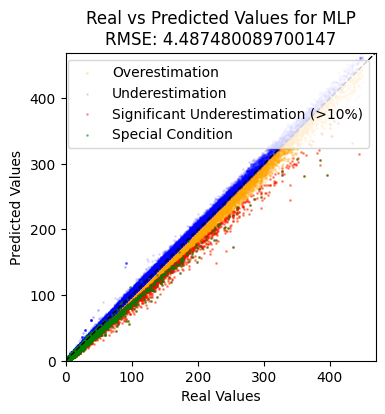

In [48]:
# Define the conditions for overestimation and underestimation
p = preds[:,9]*512
y_validation = load('datasets/preprocess/y_validation.joblib')

overestimated = y_validation >= p
underestimated = y_validation < p
significantly_underestimated = y_validation*0.9 > p
special_condition = preds[:,-1] == 1
rmse = np.sqrt(np.mean((y_validation - p)**2))

# Plot setup
plt.figure(figsize=(4, 4))

# Scatter plots for different categories
plt.scatter(y_validation[overestimated], p[overestimated], color='orange', alpha=0.2, s=1, label='Overestimation')
plt.scatter(y_validation[underestimated], p[underestimated], color='blue', alpha=0.1, s=1, label='Underestimation')
plt.scatter(y_validation[significantly_underestimated], p[significantly_underestimated], color='red', alpha=0.3, s=1, label='Significant Underestimation (>10%)')
plt.scatter(y_validation[special_condition], p[special_condition], color='green', alpha=0.4, s=1, label='Special Condition')

# Diagonal line for reference
plt.plot([0, np.max([y_validation.max(), p.max()])], [0, np.max([y_validation.max(), p.max()])], 'k--', lw=1)

# Labels, title, and limits
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title(f'Real vs Predicted Values for MLP\nRMSE: {rmse}')
plt.xlim([0, np.max([y_validation.max(), p.max()])])
plt.ylim([0, np.max([y_validation.max(), p.max()])])

# Legend
plt.legend()

# Show plot
plt.show()